# Forcing Extraction Tutorial

Use daymet data. 

In [6]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import numpy as np
import pysal
import seaborn
import fiona
import geopandas as gp
import shapely
from shapely import geometry
from os.path import dirname
import glob
import sys
import pickle
from functools import partial
from datetime import datetime

parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
import zonal_stats as zs
import meteolib as meteo
import evaplib as evap
import daymetpy as dm
import fao as fao

In [7]:
try:
    polys = glob.glob(os.path.join(parent_dir,'raw_data','north_south_polygons_elder','*.shp'))
except RuntimeError:
    print 'Cannot find polygon shapefile.'

north = gp.read_file(polys[0])
south = gp.read_file(polys[1])
elder_lon = -123.61953
elder_lat = 39.7176204

In [8]:

df = pickle.load(open('./xue_daily.p','rb'))
df = df.sort_index()
df['tmean'] = (df['tmax'] + df['tmin'])/2.0
df['es'] = meteo.es_calc(airtemp= df.tmean)
df['ea'] = df['rh']/100.0*df['es']
elevation = 426.0
df['p'] = meteo.airpress_calc(elevation)

In [9]:
# Using Eqn 50 From Allen (1998) to get solar radiation from max/min temp difference
kRs = 0.18

# get forcing dates
rng = df.index

doy = [rng[i].timetuple().tm_yday for i in range(len(rng))]
N, Rext = meteo.sun_NR(doy, elder_lat)
Rext_MJ = Rext/(10.0**6)
Rs0 = (0.75+2E-5*elevation)*Rext
tmax = df['tmax']
tmin = df['tmin']
tmean = df['tmean']
Rs = kRs*np.sqrt(tmax-tmin)*Rext
df['Rs0'] = Rs0
df['Rs'] = Rs
df['f'] = [np.min([1, Rs[i]/Rs0[i]]) for i in range(len(Rs0))]
df['Rs'] = df.f*df.Rs0
tmin = np.array(df.tmin.tolist()) + 273.15
tmax = np.array(df.tmax.tolist()) + 273.15
rs = np.array(df.Rs.tolist())/10.0**6
rs0 = np.array(df.Rs0.tolist())/10.0**6
ea = np.array(df.ea.tolist())/1000.0
STEFAN_BOLTZMANN_CONSTANT = 0.000000004903
tmp1 = STEFAN_BOLTZMANN_CONSTANT*(tmax**4 + tmin**4)/2
tmp2 = (0.34 - (0.14 * ea))
tmp3 = 1.35 * (rs / rs0) - 0.35
df['Rnl'] = tmp1 * tmp2 * tmp3*1000000.0


In [10]:
doy = [rng[i].timetuple().tm_yday for i in range(len(rng))]

rs_list = glob.glob(os.path.join('/Users/daviddralle/Desktop/daily_rs_elder','*.tif'))

daily_rad_north = {}
daily_rad_south = {}
for day,fh in enumerate(rs_list): 
    north_mean = zs.zonal_stats(raster_path=fh, vector_path=polys[0] )[0]['mean']
    south_mean = zs.zonal_stats(raster_path=fh, vector_path=polys[1] )[0]['mean'] 
    daily_rad_north[day+1] = north_mean
    daily_rad_south[day+1] = south_mean
    

/Users/daviddralle/Dropbox/research/streamflow_temp/model_development/StreamflowTempModel/lib/zonal_stats.py:117: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  src_array == nodata_value,


In [11]:
df['Rns_north'] = np.nan
df['Rns_south'] = np.nan
for i, row in df.iterrows():
    doy = i.timetuple().tm_yday
    df.ix[i, 'Rns_north'] = row.f * daily_rad_north[doy]*3600.0  # in joules/m2/day
    df.ix[i, 'Rns_south'] = row.f * daily_rad_south[doy]*3600.0

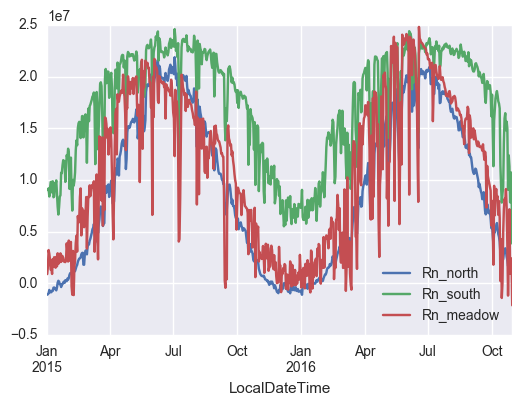

In [23]:
df['Rn_south'] = df['Rns_south'] - df['Rnl']*N/24.0
df['Rn_north'] = df['Rns_north'] - df['Rnl']*N/24.0
data = pickle.load(open('/Users/daviddralle/Desktop/netrad.p','rb'))
df['N'] = N
df['Rn_meadow'] = data
df[['Rn_north','Rn_south', 'Rn_meadow']].plot()
plt.savefig('/Users/daviddralle/Desktop/rnplot.pdf')
pickle.dump(df[['Rn_north','Rn_south','N', 'Rns_south', 'Rns_north', 'Rnl']],open('/Users/daviddralle/Desktop/rnet.p', 'wb'))

In [13]:
rew_dfs_dict = pickle.load( open( os.path.join(parent_dir,'model_data','rew_forcing.p'), "rb"))

basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)


In [14]:
basins_shape['annual_pet'] = np.nan

for i,row in basins_shape.iterrows():
    rew_id = row['cat']
    basins_shape.ix[i,'annual_pet'] = rew_dfs_dict[rew_id]['pet'].sum()*10

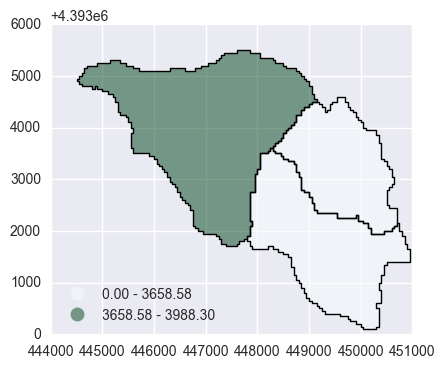

In [19]:

basins_shape.plot(column='annual_pet', scheme='QUANTILES', k=2, colormap='BuGn', legend=True)
plt.savefig('/Users/daviddralle/Desktop/PET.pdf')